# Dataset preparation using Scrapy

In [44]:
import pickle

import pandas as pd
import requests
import scrapy
from scrapy import Selector
from scrapy.crawler import CrawlerProcess

## Here we will first explore the html source code, to find out which tags contain the information we need, how to access these html tags and extract the information we need from them. Once we completed this, then we will write the script which will scrape the websites and downloads the data we need

In [2]:
source_url = 'https://archivepmo.nic.in/drmanmohansingh/all-speeches.php'

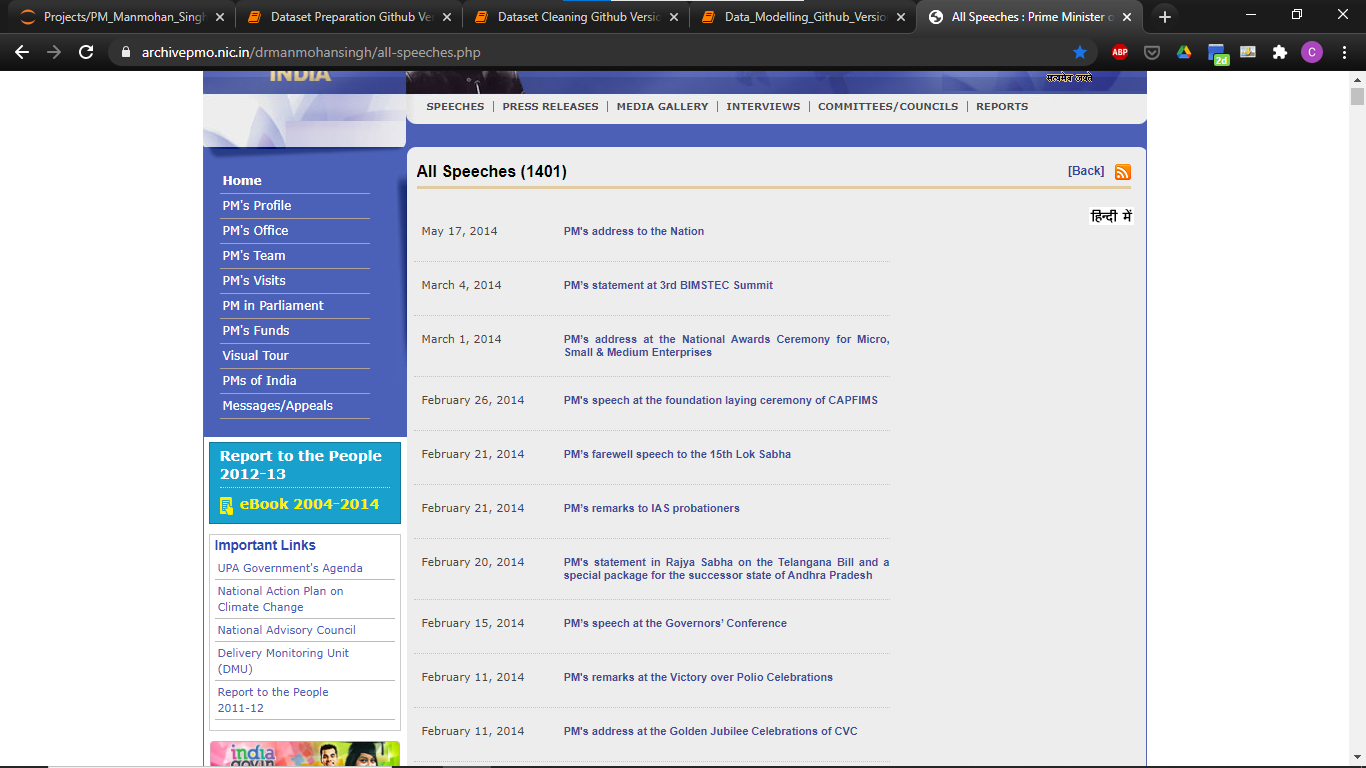

### The above page consists of links to all the speeches. So we first need to examine the html source for this and extract the links to the speeches

In [3]:
#Create the string html containing the HTML source
html = requests.get(source_url).content
#Creating a scrapy Selector object using a string with the html code
#The selector sel has selected the entire html document
sel = Selector( text = html )

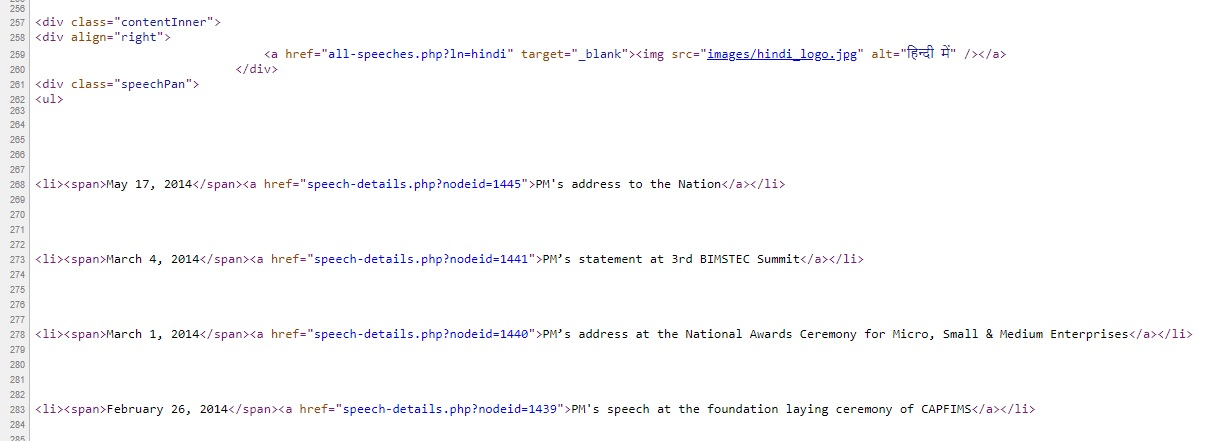

### Within the div tag whose class attribute = "speechPan", there is an ul tag(unorderd list). Within this tag, there are several list items which contain the details of the speech and links to the speech text.

In [11]:
#Using xpath method of selector object, we extracted the list items which contain the details of speeches
type(sel.xpath('//div[@class = "speechPan"]/ul/li'))

scrapy.selector.unified.SelectorList

In [12]:
len(sel.xpath('//div[@class = "speechPan"]/ul/li'))
#Total of 1401 speeches

1401

In [13]:
url_prefix = 'https://archivepmo.nic.in/drmanmohansingh/'

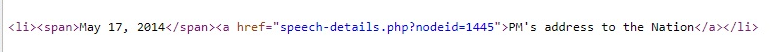

### Within each list item, we are further accessing href attribute of "a" tags i.e hyperlink tags and then extracting the text stored in it, which is nothing but the link to that particular speech. 

### But keep in mind, the link is only partial, we need to add the url_prefix defined earlier to get the complete link to the speech

In [14]:
#Extracting paths to different speeches
url_suffixes = sel.xpath('//div[@class = "speechPan"]/ul//li').xpath('./a/@href').extract()
len(url_suffixes)

1401

In [15]:
# Creating complete urls by adding the url prefix to the paths
urls = [url_prefix +url_suffix for url_suffix in url_suffixes]

urls[:5]

['https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1445',
 'https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1441',
 'https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1440',
 'https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1439',
 'https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1438']

In [16]:
type(sel.xpath('//div[@class = "speechPan"]/ul/li')), type(sel.xpath('//div[@class = "speechPan"]/ul/li')[0])

(scrapy.selector.unified.SelectorList, scrapy.selector.unified.Selector)

In [17]:
# extract_first method extracts the entire html code within the 1st object of SelectorList
(sel.xpath('//div[@class = "speechPan"]/ul/li').extract_first())

'<li><span>May 17, 2014</span><a href="speech-details.php?nodeid=1445">PM\'s address to the Nation</a></li>'

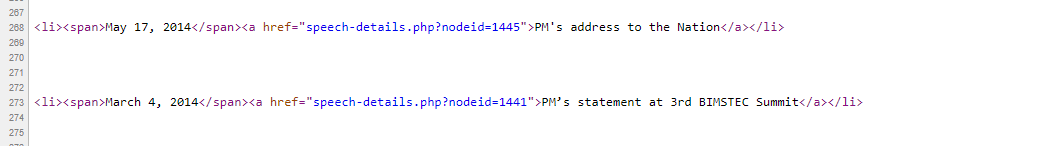

In [18]:
#Extracting speech date by accessing the text within the span tag
speech_date = sel.xpath('//div[@class = "speechPan"]/ul/li')[1].xpath('./span/text()').extract_first()
speech_date

'March 4, 2014'

In [19]:
#Extracting speech Name by accessing the text within the "a" tag
speech_title = sel.xpath('//div[@class = "speechPan"]/ul/li')[1].xpath('./a/text()').extract_first()
speech_title

'PM’s statement at 3rd BIMSTEC Summit'

In [20]:
#Extracting url suffix
url_suffix = sel.xpath('//div[@class = "speechPan"]/ul/li')[1].xpath('./a/@href').extract_first()
url_suffix

'speech-details.php?nodeid=1441'

In [21]:
#creating completer url
url_speech = url_prefix + url_suffix
url_speech

'https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1441'

## Now, we are going to the above page, i.e pages where speeches are there. We will explore the speech page to figure out how to extract  the speech text

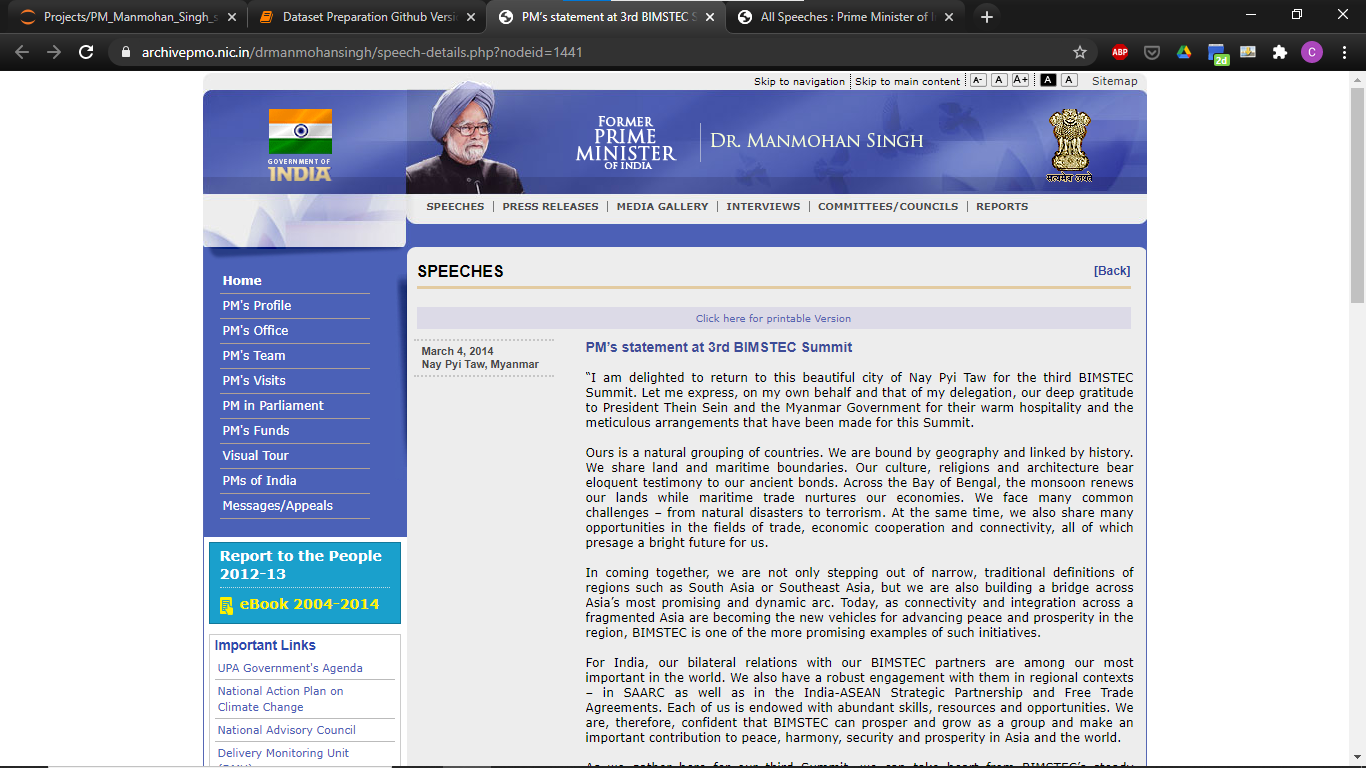

In [24]:
#Create the string html containing the HTML source
html_speech = requests.get( url_speech ).content
#Creating a scrapy Selector object using a string with the html code
#The selector sel2 has selected the entire html document of speech page
sel2 = Selector(text = html_speech)

### Below is the html source code of speech page. The div tag whose class attribute = "contentInner" has the information we need, i.e, date,place,title and text of speech

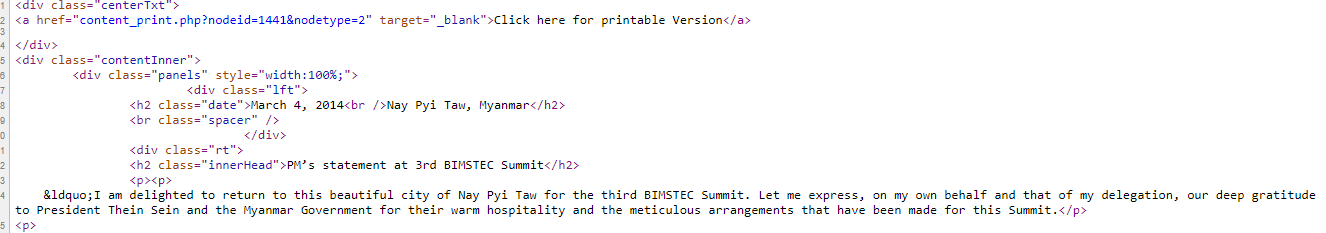

In [25]:
len(sel2.xpath('//*'))

165

In [26]:
# Selecting all the tags whose class = "innerHead" but here there is only one such tag. 
# Extracting the text within that tag gives us the speech Name
(sel2.xpath('//*[@class = "innerHead"]/text()')).extract_first()

'PM’s statement at 3rd BIMSTEC Summit'

In [27]:
#Within the div tag whose class = "contentInner", accessing text within the tag
(sel2.xpath('//div[@class = "contentInner"]//h2[@class = "date"]/text()'))

[<Selector xpath='//div[@class = "contentInner"]//h2[@class = "date"]/text()' data='March 4, 2014'>,
 <Selector xpath='//div[@class = "contentInner"]//h2[@class = "date"]/text()' data='Nay Pyi Taw, Myanmar'>]

In [28]:
#Accessing the date
(sel2.xpath('//div[@class = "contentInner"]//h2[@class = "date"]/text()'))[0].extract()

'March 4, 2014'

In [29]:
#Accessing the place
(sel2.xpath('//div[@class = "contentInner"]//h2[@class = "date"]/text()'))[1].extract()

'Nay Pyi Taw, Myanmar'

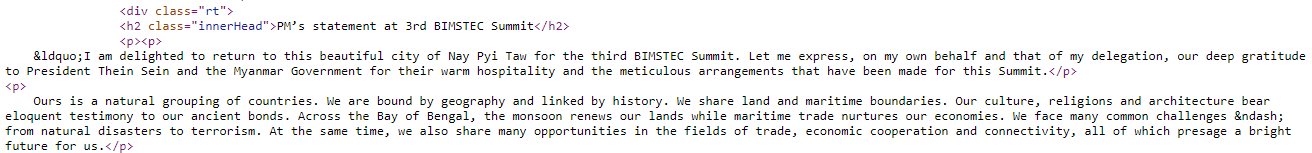

### Within the div tag whose class = "contentInner",there are paragraph tags("p") which contain the speech text

In [34]:
#Till now we have used xpath for accessing the tags and extracting information
#Here while accessing paragraphs, there was some duplication because of some issue with Javascript
#Hence using css selector here to access the text within paragraph tags
#It returns list of strings, where each string is the text within each pararaph tag
paras = sel2.css('div.contentInner div.rt').css('p::text').extract()
len(paras)

20

In [35]:
paras[1]

'\r\n\tOurs is a natural grouping of countries. We are bound by geography and linked by history. We share land and maritime boundaries. Our culture, religions and architecture bear eloquent testimony to our ancient bonds. Across the Bay of Bengal, the monsoon renews our lands while maritime trade nurtures our economies. We face many common challenges – from natural disasters to terrorism. At the same time, we also share many opportunities in the fields of trade, economic cooperation and connectivity, all of which presage a bright future for us.'

In [39]:
#Joining paras to create speech
speech = "".join(paras)
print(speech[:1000])


	“I am delighted to return to this beautiful city of Nay Pyi Taw for the third BIMSTEC Summit. Let me express, on my own behalf and that of my delegation, our deep gratitude to President Thein Sein and the Myanmar Government for their warm hospitality and the meticulous arrangements that have been made for this Summit.
	Ours is a natural grouping of countries. We are bound by geography and linked by history. We share land and maritime boundaries. Our culture, religions and architecture bear eloquent testimony to our ancient bonds. Across the Bay of Bengal, the monsoon renews our lands while maritime trade nurtures our economies. We face many common challenges – from natural disasters to terrorism. At the same time, we also share many opportunities in the fields of trade, economic cooperation and connectivity, all of which presage a bright future for us.
	In coming together, we are not only stepping out of narrow, traditional definitions of regions such as South Asia or Southeast As


## Now, we have completed the task of collecting speech name, date, place and text from start to end. Now, we need to automate this process and extract speeches from all links

In [40]:
class MMS_Speech_Spider(scrapy.Spider):
    name = "pm_mms_speech_spider"
    
    def start_requests(self):
        url = 'https://archivepmo.nic.in/drmanmohansingh/all-speeches.php'
        yield scrapy.Request( url = url,callback = self.parse_front )
        
    def parse_front( self, response ):
        # Selecting speech link blocks
        speech_link_blocks = response.xpath('//div[@class = "speechPan"]/ul/li')
        for link_block in speech_link_blocks:
            #Extracting speech title
            #title = link_block.xpath('./a/text()').extract_first()
            #Extracting speech date
            #date = link_block.xpath('./span/text()').extract_first()
            
            #Extracting speech url
            url_suffix = link_block.xpath('./a/@href').extract_first()
            speech_url = url_prefix + url_suffix
            
            # Follow the links to the next parser
            yield response.follow( url = speech_url,callback = self.parse_pages ) 
        
    def parse_pages( self, response ):
        
        #Extracting url
        speech_url = response.url
        
        #Extracting title of speech
        title = (response.xpath('//*[@class = "innerHead"]/text()')).extract_first()
        
        #Extracting date of speech
        date = (response.xpath('//div[@class = "contentInner"]//h2[@class = "date"]/text()'))[0].extract()
        
        #Extracting place of speech
        place = (response.xpath('//div[@class = "contentInner"]//h2[@class = "date"]/text()'))[1].extract()
        
        #Extracting speech text
        text  = "".join((response.css('div.contentInner div.rt')).css('p::text').extract())
        
        #Storing in respective dictionaries
        place_dict[title] = place
        date_dict[title] = date
        url_dict[title] = speech_url
        text_dict[title] = text
        

In [41]:
date_dict = {}
place_dict = {}
text_dict = {}
url_dict = {}
url_prefix = 'https://archivepmo.nic.in/drmanmohansingh/'
process = CrawlerProcess()
process.crawl(MMS_Speech_Spider)
process.start()

2020-04-09 11:13:56 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-04-09 11:13:56 [scrapy.utils.log] INFO: Versions: lxml 4.2.1.0, libxml2 2.9.8, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)], pyOpenSSL 17.5.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.4.2, Platform Windows-10-10.0.18362-SP0
2020-04-09 11:13:56 [scrapy.crawler] INFO: Overridden settings: {}
2020-04-09 11:13:56 [scrapy.extensions.telnet] INFO: Telnet Password: 847f123bb7b465ee
2020-04-09 11:13:56 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats']
2020-04-09 11:13:58 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.DownloadTimeoutMiddleware',
 'scrap

2020-04-09 11:14:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=8> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=9> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=10> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=12> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=13> (referer: https://archivepm

2020-04-09 11:14:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=46> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=48> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=45> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=50> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=52> (referer: https://archive

2020-04-09 11:14:05 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=86> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:05 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=87> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=88> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=91> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=106> (referer: https://archiv

2020-04-09 11:14:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=129> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=133> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=130> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=134> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=135> (referer: https://ar

2020-04-09 11:14:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=166> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=169> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=170> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=171> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=172> (referer: https://ar

2020-04-09 11:14:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=207> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=206> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=208> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=209> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=210> (referer: https://ar

2020-04-09 11:14:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=246> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=247> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=248> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=249> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=250> (referer: https://ar

2020-04-09 11:14:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=283> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=285> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=286> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=288> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=289> (referer: https://ar

2020-04-09 11:14:17 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=360> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:17 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=373> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:17 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=365> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:17 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=366> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:17 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=367> (referer: https://ar

2020-04-09 11:14:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=405> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=406> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=407> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=408> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=409> (referer: https://ar

2020-04-09 11:14:19 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=479> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:19 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=481> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:19 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=483> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:19 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=480> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:19 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=482> (referer: https://ar

2020-04-09 11:14:20 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=455> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:20 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=454> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:20 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=456> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:20 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=490> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:20 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=457> (referer: https://ar

2020-04-09 11:14:21 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=524> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:21 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=530> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:21 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=528> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:21 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=531> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:21 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=532> (referer: https://ar

2020-04-09 11:14:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=564> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=568> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=571> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=572> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=569> (referer: https://ar

2020-04-09 11:14:24 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=646> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:24 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=648> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:24 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=647> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:24 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=651> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:24 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=652> (referer: https://ar

2020-04-09 11:14:25 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=686> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:25 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=687> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:25 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=688> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:25 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=689> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:25 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=690> (referer: https://ar

2020-04-09 11:14:26 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=727> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:26 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=728> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:26 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=730> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:26 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=732> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:26 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=733> (referer: https://ar

2020-04-09 11:14:27 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=764> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=768> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=770> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=771> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=773> (referer: https://ar

2020-04-09 11:14:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=844> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=848> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=849> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=850> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=851> (referer: https://ar

2020-04-09 11:14:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=925> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=926> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=928> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=927> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=931> (referer: https://ar

2020-04-09 11:14:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=966> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=967> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=965> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=968> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=969> (referer: https://ar

2020-04-09 11:14:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1043> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1044> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1042> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1045> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1046> (referer: https

2020-04-09 11:14:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1079> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1082> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1083> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1085> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1084> (referer: https

2020-04-09 11:14:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1139> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1138> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1133> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1140> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1137> (referer: https

2020-04-09 11:14:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1183> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1181> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1444> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1184> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1185> (referer: https

2020-04-09 11:14:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1224> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1225> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1226> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1229> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1230> (referer: https

2020-04-09 11:14:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1268> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1269> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1271> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1273> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1276> (referer: https

2020-04-09 11:14:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1311> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1312> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1316> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1314> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1317> (referer: https

2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1442> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1351> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1354> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1355> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1356> (referer: https

2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1398> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1399> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1400> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1402> (referer: https://archivepmo.nic.in/drmanmohansingh/all-speeches.php)
2020-04-09 11:14:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://archivepmo.nic.in/drmanmohansingh/speech-details.php?nodeid=1401> (referer: https

In [47]:
len(date_dict),len(place_dict),len(text_dict),len(url_dict)

(1380, 1380, 1380, 1380)

In [45]:
with open('date_dict.pickle', 'wb') as handle:
    pickle.dump(date_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('place_dict.pickle', 'wb') as handle:
    pickle.dump(place_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('url_dict.pickle', 'wb') as handle:
    pickle.dump(url_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('text_dict.pickle', 'wb') as handle:
    pickle.dump(text_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Wall time: 6.95 ms


In [51]:
#Combing the data into a single dataframe
date_df = pd.DataFrame.from_dict(date_dict, orient='index',columns= ['date'])
place_df = pd.DataFrame.from_dict(place_dict, orient='index', columns= ['place'])
text_df = pd.DataFrame.from_dict(text_dict, orient='index', columns= ['text'])
url_df = pd.DataFrame.from_dict(url_dict, orient='index', columns= ['url'])

df_combined = pd.concat([date_df, place_df,url_df,text_df], axis=1, sort=False, join = 'inner')
df_combined.index.rename('title',inplace=True)
df_combined.reset_index(drop = False,inplace= True)

df_combined.head()

,title,date,place,url,text
0,PM's address to the Nation,"September 21, 2012",New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,"\r\n\tMy dear brothers and sisters,\r\n\tI am ..."
1,PM’s address at the National Awards Ceremony f...,"March 1, 2014",New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,\r\n\t“I am very happy to participate in the N...
2,PM’s statement at 3rd BIMSTEC Summit,"March 4, 2014","Nay Pyi Taw, Myanmar",https://archivepmo.nic.in/drmanmohansingh/spee...,\r\n\t“I am delighted to return to this beauti...
3,PM’s speech at the Governors’ Conference,"February 15, 2014",New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,\r\n\tFollowing is the text of the Prime Minis...
4,PM's address at the Conference of State Minori...,"January 13, 2014",New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,\r\n\t“I am very happy to participate once aga...


In [50]:
#Storing the dataset into excel file
df_combined.to_excel('PM_MMS_Speech_2.xlsx',index=False)